<a href="https://colab.research.google.com/github/human1abs/portfolio/blob/main/ATE-Counterfactual-Analysis-Diets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Diet and Weight Loss - Estimation of Causal Effect and Counterfactual Analysis

There are two kinds of methods for data imputation - purely statistical and based on causal analysis. In the following, I am going to demonstrate how the choice if imputation strategy can influence our models.


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Dataset
I will use a dataset downloaded freely from Kaggle which shows how weights of 78 people have changed 6 weeks after undertaking three separate types of diets.

In [ ]:
np.random.seed(42)

In [ ]:
food_diet = pd.read_csv("foodDiet.csv")

In [ ]:
food_diet

,Person,gender,Age,Height,pre.weight,Diet,weight6weeks
0,25,0,41,171,60,2,60.0
1,26,0,32,174,103,2,103.0
2,1,0,22,159,58,1,54.2
3,2,0,46,192,60,1,54.0
4,3,0,55,170,64,1,63.3
...,...,...,...,...,...,...,...
73,74,1,35,183,83,3,80.2
74,75,1,49,177,84,3,79.9
75,76,1,28,164,85,3,79.7
76,77,1,40,167,87,3,77.8


## 1. Data Cleaning and Feature Engineering

In [ ]:
food_diet.isnull().sum()

Person          0
gender          0
Age             0
Height          0
pre.weight      0
Diet            0
weight6weeks    0
dtype: int64

In [ ]:
food_diet = food_diet.drop(columns=["Height", "Person"])
food_diet.rename(columns={'Age': 'age', 'pre.weight': 'start_weight',
                          'Diet': 'diet', 'weight6weeks': 'weight_in_6_weeks'}, inplace=True)
food_diet = food_diet[['gender', 'age', 'diet', 'start_weight', 'weight_in_6_weeks']]

In [ ]:
food_diet

,gender,age,diet,start_weight,weight_in_6_weeks
0,0,41,2,60,60.0
1,0,32,2,103,103.0
2,0,22,1,58,54.2
3,0,46,1,60,54.0
4,0,55,1,64,63.3
...,...,...,...,...,...
73,1,35,3,83,80.2
74,1,49,3,84,79.9
75,1,28,3,85,79.7
76,1,40,3,87,77.8


In [ ]:
food_diet.corr(numeric_only=False)

,gender,age,diet,start_weight,weight_in_6_weeks
gender,1.000000,0.018422,0.023479,0.642679,0.611748
age,0.018422,1.000000,-0.127707,-0.006265,0.010472
diet,0.023479,-0.127707,1.000000,0.039234,-0.048050
start_weight,0.642679,-0.006265,0.039234,1.000000,0.958449
weight_in_6_weeks,0.611748,0.010472,-0.048050,0.958449,1.000000


Well, well... **diet** and **age** have a quite and interesting correlation, which is the strongest relationship **diet** has with variables in that dataset. Let's calibrate **age** into age groups and see if that would still be the case.

### Putting Ages into Age groups
The youngest subject of that study is 16, while the oldest one - 60 years of age. Therefore, we can divide **age** into three subgroups - 15 to 30, 31 to 45, 46 to 60 years of age.

In [ ]:
bins = [15, 30, 45, 60]
labels = [1, 2, 3]

In [ ]:
age_groups = pd.cut(food_diet.age, bins, labels=labels)

In [ ]:
age_groups

0     2
1     2
2     1
3     3
4     3
     ..
73    2
74    3
75    1
76    2
77    3
Name: age, Length: 78, dtype: category
Categories (3, int64): [1 < 2 < 3]

In [ ]:
food_diet.age = age_groups
food_diet

,gender,age,diet,start_weight,weight_in_6_weeks
0,0,2,2,60,60.0
1,0,2,2,103,103.0
2,0,1,1,58,54.2
3,0,3,1,60,54.0
4,0,3,1,64,63.3
...,...,...,...,...,...
73,1,2,3,83,80.2
74,1,3,3,84,79.9
75,1,1,3,85,79.7
76,1,2,3,87,77.8


After stratifying **age** into three age groups, we can see that **diet** and **age** continue to have a relatively strong negative correlation, especially compared to **diet**'s correlation with any other variable:

In [ ]:
food_diet.corr(numeric_only=False)

,gender,age,diet,start_weight,weight_in_6_weeks
gender,1.000000,0.001504,0.023479,0.642679,0.611748
age,0.001504,1.000000,-0.078172,-0.037167,-0.010597
diet,0.023479,-0.078172,1.000000,0.039234,-0.048050
start_weight,0.642679,-0.037167,0.039234,1.000000,0.958449
weight_in_6_weeks,0.611748,-0.010597,-0.048050,0.958449,1.000000


Maybe it's not a bad idea to account for this observation in our causal model.

## 2. Causal effect of Diet on Weight Loss
In this part, we are going to estimate the causal effect of **diet** on **weight_in_6_weeks** by using Propensity score matching. As the treatment in this case is a variable with discrete, non-binary values, I am going to use 1 vs All approach, meaning we will take a look into three cases in which we will seek to estimate the effect of getting on one of the three diets as opposed to not taking it (here, the 0 values are represented by the other 2 diets).

But first, lets create the causal model.

In [ ]:
import dowhy
import networkx as nx
import dowhy.gcm as gcm
import dowhy.api
from dowhy import CausalModel

In [ ]:
food_diet_est_ate = food_diet.copy()

In [ ]:
def food_diet_type_one_vs_rest(df, diet_type):
    diet = []
    for i in range(len(df)):
        if df.diet[i] == diet_type:
            diet.append(1)
        else:
            diet.append(0)
    df['diet'] = diet
    return df

### Causal Model

In [ ]:
graph_14 = nx.DiGraph([('age', 'start_weight'), ('age', 'weight_in_6_weeks'), ('gender', 'weight_in_6_weeks'),
                        ('start_weight', 'weight_in_6_weeks'), ('gender', 'start_weight'),
                        ('age', 'diet'), ('diet', 'weight_in_6_weeks')])

![causal_model.png](attachment:causal_model.png)

### Average Treatment Effect of Diet 1

In [ ]:
food_diet_ate_diet_1 = food_diet_type_one_vs_rest(food_diet_est_ate.copy(), 1)
model_14_diet_1 = CausalModel(
        data = food_diet_ate_diet_1,
        graph=graph_14,
        treatment='diet',
        outcome='weight_in_6_weeks',
        common_causes='age')

In [ ]:
identified_estimand= model_14_diet_1.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d                             
───────(E[weight_in_6_weeks|age])
d[diet]                          
Estimand assumption 1, Unconfoundedness: If U→{diet} and U→weight_in_6_weeks then P(weight_in_6_weeks|diet,age,U) = P(weight_in_6_weeks|diet,age)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



In [ ]:
causal_estimate_match_d1 = model_14_diet_1.estimate_effect(identified_estimand,
                                              method_name="backdoor.propensity_score_matching",
                                              target_units="ate")
print(causal_estimate_match_d1)
print("Causal Estimate is " + str(causal_estimate_match_d1.value))
interpretation = causal_estimate_match_d1.interpret(method_name="textual_effect_interpreter")

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d                             
───────(E[weight_in_6_weeks|age])
d[diet]                          
Estimand assumption 1, Unconfoundedness: If U→{diet} and U→weight_in_6_weeks then P(weight_in_6_weeks|diet,age,U) = P(weight_in_6_weeks|diet,age)

## Realized estimand
b: weight_in_6_weeks~diet+age
Target units: ate

## Estimate
Mean value: -4.084615384615384

Causal Estimate is -4.084615384615384
Increasing the treatment variable(s) [diet] from 0 to 1 causes an increase of -4.084615384615384 in the expected value of the outcome [['weight_in_6_weeks']], over the data distribution/population represented by the dataset.


### Average Treatment Effect of Diet 2

In [ ]:
food_diet_ate_diet_2 = food_diet_type_one_vs_rest(food_diet_est_ate.copy(), 2)
model_14_diet_2 = CausalModel(
        data = food_diet_ate_diet_2,
        graph=graph_14,
        treatment='diet',
        outcome='weight_in_6_weeks',
        common_causes='age')

In [ ]:
identified_estimand= model_14_diet_2.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d                             
───────(E[weight_in_6_weeks|age])
d[diet]                          
Estimand assumption 1, Unconfoundedness: If U→{diet} and U→weight_in_6_weeks then P(weight_in_6_weeks|diet,age,U) = P(weight_in_6_weeks|diet,age)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



In [ ]:
causal_estimate_match_d2 = model_14_diet_2.estimate_effect(identified_estimand,
                                              method_name="backdoor.propensity_score_matching",
                                              target_units="ate")
print(causal_estimate_match_d2)
print("Causal Estimate is " + str(causal_estimate_match_d2.value))
interpretation = causal_estimate_match_d2.interpret(method_name="textual_effect_interpreter")

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d                             
───────(E[weight_in_6_weeks|age])
d[diet]                          
Estimand assumption 1, Unconfoundedness: If U→{diet} and U→weight_in_6_weeks then P(weight_in_6_weeks|diet,age,U) = P(weight_in_6_weeks|diet,age)

## Realized estimand
b: weight_in_6_weeks~diet+age
Target units: ate

## Estimate
Mean value: -2.7435897435897445

Causal Estimate is -2.7435897435897445
Increasing the treatment variable(s) [diet] from 0 to 1 causes an increase of -2.7435897435897445 in the expected value of the outcome [['weight_in_6_weeks']], over the data distribution/population represented by the dataset.


### Average Treatment Effect of Diet 3

In [ ]:
food_diet_ate_diet_3 = food_diet_type_one_vs_rest(food_diet_est_ate.copy(), 3)
model_14_diet_3 = CausalModel(
        data = food_diet_ate_diet_3,
        graph=graph_14,
        treatment='diet',
        outcome='weight_in_6_weeks',
        common_causes='age')

In [ ]:
identified_estimand= model_14_diet_3.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d                             
───────(E[weight_in_6_weeks|age])
d[diet]                          
Estimand assumption 1, Unconfoundedness: If U→{diet} and U→weight_in_6_weeks then P(weight_in_6_weeks|diet,age,U) = P(weight_in_6_weeks|diet,age)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



In [ ]:
causal_estimate_match_d3 = model_14_diet_3.estimate_effect(identified_estimand,
                                              method_name="backdoor.propensity_score_matching",
                                              target_units="ate")
print(causal_estimate_match_d3)
print("Causal Estimate is " + str(causal_estimate_match_d3.value))
interpretation = causal_estimate_match_d1.interpret(method_name="textual_effect_interpreter")

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d                             
───────(E[weight_in_6_weeks|age])
d[diet]                          
Estimand assumption 1, Unconfoundedness: If U→{diet} and U→weight_in_6_weeks then P(weight_in_6_weeks|diet,age,U) = P(weight_in_6_weeks|diet,age)

## Realized estimand
b: weight_in_6_weeks~diet+age
Target units: ate

## Estimate
Mean value: -4.357692307692307

Causal Estimate is -4.357692307692307
Increasing the treatment variable(s) [diet] from 0 to 1 causes an increase of -4.084615384615384 in the expected value of the outcome [['weight_in_6_weeks']], over the data distribution/population represented by the dataset.


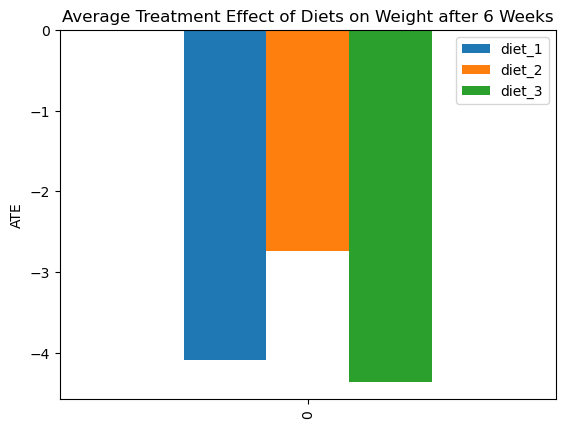

In [ ]:
df_plot = pd.DataFrame()
df_plot['diet_1'] = [-4.084615384615384]
df_plot['diet_2'] = [-2.7435897435897445]
df_plot['diet_3'] = [-4.357692307692307]

df_plot.plot.bar(title="Average Treatment Effect of Diets on Weight after 6 Weeks")
plt.ylabel('ATE')
plt.legend()

## 3. Counterfactual Analysis

In [ ]:
def evaluating_causal_structure(graph, dataframe):
    causal_model = gcm.InvertibleStructuralCausalModel(graph)
    gcm.auto.assign_causal_mechanisms(causal_model, dataframe)
    gcm.fit(causal_model, dataframe)
    print(gcm.evaluate_causal_model(causal_model, dataframe, evaluate_causal_structure=True))
    return causal_model

Test permutations of given graph: 100%|█████████| 50/50 [00:00<00:00, 97.89it/s]


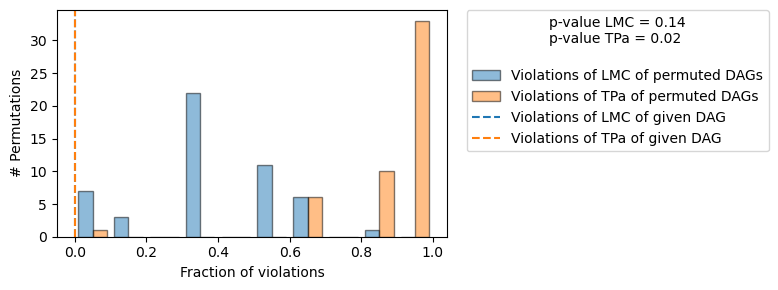

Evaluated the performance of the causal mechanisms and the invertibility assumption of the causal mechanisms and the overall average KL divergence between generated and observed distribution and the graph structure. The results are as follows:

==== Evaluation of Causal Mechanisms ====
The used evaluation metrics are:
- KL divergence (only for root-nodes): Evaluates the divergence between the generated and the observed distribution.
- Mean Squared Error (MSE): Evaluates the average squared differences between the observed values and the conditional expectation of the causal mechanisms.
- Normalized MSE (NMSE): The MSE normalized by the standard deviation for better comparison.
- R2 coefficient: Indicates how much variance is explained by the conditional expectations of the mechanisms. Note, however, that this can be misleading for nonlinear relationships.
- F1 score (only for categorical non-root nodes): The harmonic mean of the precision and recall indicating the goodness of the under

In [ ]:
causal_model_14 = evaluating_causal_structure(graph_14, food_diet)

As we can see, this model is not rejected by the doWhy rigurous causal structure evaluation metrics, so we might be one the right path here... Luckily, our dataset doesn't have any missing values. Therefore, I'm going to modify it a little bit in order to demonstrate the concept of imputation via counterfactual analysis.

In [ ]:
food_diet_cfs = food_diet.copy()

In [ ]:
weight_in_6_weeks_diet_1 = []
weight_in_6_weeks_diet_2 = []
weight_in_6_weeks_diet_3 = []

for i in range(len(food_diet_cfs)):
    weight_in_6_weeks_diet_1.append(food_diet_cfs.weight_in_6_weeks[i] if food_diet_cfs.diet[i] == 1 else np.nan)
    weight_in_6_weeks_diet_2.append(food_diet_cfs.weight_in_6_weeks[i] if food_diet_cfs.diet[i] == 2 else np.nan)
    weight_in_6_weeks_diet_3.append(food_diet_cfs.weight_in_6_weeks[i] if food_diet_cfs.diet[i] == 3 else np.nan)

food_diet_cfs['weight_in_6_weeks_diet_1'] = weight_in_6_weeks_diet_1
food_diet_cfs['weight_in_6_weeks_diet_2'] = weight_in_6_weeks_diet_2
food_diet_cfs['weight_in_6_weeks_diet_3'] = weight_in_6_weeks_diet_3
food_diet_cfs = food_diet_cfs.drop(columns='weight_in_6_weeks')

In [ ]:
food_diet_cfs.head(11)

,gender,age,diet,start_weight,weight_in_6_weeks_diet_1,weight_in_6_weeks_diet_2,weight_in_6_weeks_diet_3
0,0,2,2,60,NaN,60.0,NaN
1,0,2,2,103,NaN,103.0,NaN
2,0,1,1,58,54.2,NaN,NaN
3,0,3,1,60,54.0,NaN,NaN
4,0,3,1,64,63.3,NaN,NaN
5,0,2,1,64,61.1,NaN,NaN
6,0,3,1,65,62.2,NaN,NaN
7,0,3,1,66,64.0,NaN,NaN
8,0,2,1,67,65.0,NaN,NaN
9,0,1,1,69,60.5,NaN,NaN


In [ ]:
weight_diet_1 = np.nan_to_num(food_diet_cfs.weight_in_6_weeks_diet_1)
weight_diet_2 = np.nan_to_num(food_diet_cfs.weight_in_6_weeks_diet_2)
weight_diet_3 = np.nan_to_num(food_diet_cfs.weight_in_6_weeks_diet_3)

for i in range(len(food_diet)):

    obs_data = food_diet[i:i+1]

    if food_diet.diet[i] == 1:
        counterfactual_data2 = gcm.counterfactual_samples(causal_model_14,
                                                  {'diet': lambda x: 2},
                                                  observed_data = obs_data)

        counterfactual_data3 = gcm.counterfactual_samples(causal_model_14,
                                                  {'diet': lambda x: 3},
                                                  observed_data = obs_data)

        weight_diet_2[i] = counterfactual_data2['weight_in_6_weeks']
        weight_diet_3[i] = counterfactual_data3['weight_in_6_weeks']

    elif food_diet.diet[i] == 2:
        counterfactual_data1 = gcm.counterfactual_samples(causal_model_14,
                                                  {'diet': lambda x: 1},
                                                  observed_data = obs_data)

        counterfactual_data3 = gcm.counterfactual_samples(causal_model_14,
                                                  {'diet': lambda x: 3},
                                                  observed_data = obs_data)

        weight_diet_1[i] = counterfactual_data1['weight_in_6_weeks']
        weight_diet_3[i] = counterfactual_data3['weight_in_6_weeks']

    elif food_diet.diet[i] == 3:
        counterfactual_data1 = gcm.counterfactual_samples(causal_model_14,
                                                  {'diet': lambda x: 1},
                                                  observed_data = obs_data)

        counterfactual_data2 = gcm.counterfactual_samples(causal_model_14,
                                                  {'diet': lambda x: 2},
                                                  observed_data = obs_data)

        weight_diet_1[i] = counterfactual_data1['weight_in_6_weeks']
        weight_diet_2[i] = counterfactual_data2['weight_in_6_weeks']

food_diet_cfs['weight_in_6_weeks_diet_1'] = weight_diet_1
food_diet_cfs['weight_in_6_weeks_diet_2'] = weight_diet_2
food_diet_cfs['weight_in_6_weeks_diet_3'] = weight_diet_3

food_diet_cfs.head(11)

,gender,age,diet,start_weight,weight_in_6_weeks_diet_1,weight_in_6_weeks_diet_2,weight_in_6_weeks_diet_3
0,0,2,2,60,60.926096,60.000000,59.073904
1,0,2,2,103,103.926096,103.000000,102.073904
2,0,1,1,58,54.200000,53.273904,52.347807
3,0,3,1,60,54.000000,53.073904,52.147807
4,0,3,1,64,63.300000,62.373904,61.447807
5,0,2,1,64,61.100000,60.173904,59.247807
6,0,3,1,65,62.200000,61.273904,60.347807
7,0,3,1,66,64.000000,63.073904,62.147807
8,0,2,1,67,65.000000,64.073904,63.147807
9,0,1,1,69,60.500000,59.573904,58.647807
